### **Load data from .pkl file**

In [1]:
from collections import Counter
# Third-party library imports
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import stft
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

In [2]:
with open("Data_After_Processing.pkl", "rb") as file:
    data_after_processing = pickle.load(file)

### **Extract Features**

After the steps of exploring and preprocessing the data, feature extraction focuses on the 4 frequency bands **delta**, **theta**, **alpha**, and **beta**, based on the correlation of these bands with mental states by analyzing the Power Spectral Density (PSD).

- **STFT** (Short-Time Fourier Transform) is a method for analyzing signals in both time and frequency domains. It improves on FFT by dividing the signal into smaller segments (epochs) and applying FFT to each segment. This helps observe the frequency spectrum changes over time, capturing fluctuations in brain activity, particularly transitions between attention states such as focused, unfocused, and drowsy.

- To improve accuracy, the **Blackman-Harris window** is used, which helps minimize spectral leakage when the signal is abruptly cut off. This window smooths the signal's edges, reduces noise, and enhances the accuracy of the Fourier transform, leading to more precise frequency analysis.

In [3]:
# 1. The Blackman-Harris window function.
def blackman_harris_window(M=128):
    t_win = np.arange(0, M)
    window_blackman = 0.42 - 0.5 * np.cos((2 * np.pi * t_win) / (M - 1)) + 0.08 * np.cos((4 * np.pi * t_win) / (M - 1))
    return window_blackman

- Next, STFT is computed on the EEG signal to analyze the frequency components. The power spectral density (PSD) is calculated from the STFT, which reflects the energy level of the signal at different frequencies. This is an important step for subsequently extracting frequency features that will be used for classifying attention states.

In [4]:
# 2. Function to compute STFT and spectral power
def compute_stft_power(data, fs, window, nperseg, nfft=1024):
    f, t, Zxx = stft(data, fs=fs, window=window, nperseg=nperseg, noverlap=0, nfft=nfft,
                     detrend=False, return_onesided=True, boundary='zeros', padded=True)
    power = (np.abs(Zxx)) ** 2
    # Add the channel dimension if only 2 dimensions are present (Ensure the result has 3 dimensions: num_channels, num_frequencies, num_segments)
    return power[np.newaxis, :, :] if power.ndim == 2 else power

- The EEG signal is divided into important frequency bands: **delta (0.5–4 Hz)**, **theta (4–8 Hz)**, **alpha (8–13 Hz)**, and **beta (13–30 Hz)**, with each band reflecting a characteristic brain activity and being closely related to different mental attention states.

- To extract features from these bands, the average power of each band is calculated for each EEG channel. This process helps analyze the energy levels in the frequency bands and highlights features associated with each attention state of the test participants.

In [5]:
# 3. Function to calculate the average power in a 0.5Hz frequency band
def average_power_by_band(power, fs, bands):
    if len(power.shape) < 3:
        raise ValueError("Input 'power' must have at least 3 dimensions: (num_channels, num_frequencies, num_segments)")

    num_channels, num_frequencies, num_segments = power.shape
    
    freqs = np.linspace(0, fs / 2, num_frequencies)  # Frequencies corresponding to the bins
    band_power = np.zeros((num_channels, len(bands), num_segments))

    for band_idx, (band_name, (low_freq, high_freq)) in enumerate(bands.items()):
        # Identify the frequency bin indices in the frequency band range
        band_indices = np.where((freqs >= low_freq) & (freqs < high_freq))[0]
        if len(band_indices) == 0:
            raise ValueError(f"Frequency bins not found for the band {band_name}. Check the frequency band range.")
        # Calculate the average over the frequency bin indices
        band_power[:, band_idx, :] = np.mean(power[:, band_indices, :], axis=1)

    return band_power

- By applying a moving average with a 15-second time window, the EEG signal is smoothed, helping to reduce random noise and minimize short-term fluctuations in the signal. This makes the signal more stable and easier to analyze.

In [6]:
# 4. Function to calculate the moving average over a 15-second window
def moving_average_window(data, window_size=15):
    num_segments = data.shape[2] - window_size + 1
    averaged_data = np.zeros((data.shape[0], data.shape[1], num_segments))
    for chn in range(data.shape[0]):
        for j in range(num_segments):
            averaged_data[chn, :, j] = np.average(data[chn, :, j:j + window_size], axis=1)
    return averaged_data

- The power features, after processing, are converted into feature vectors, helping the machine learning model distinguish between attention states. The logarithm is applied to reduce the influence of outliers and normalize the features.

In [7]:
# 5. Function to convert data into feature vectors
def create_model_features(power_ave):
    num_channels, num_bins, num_segments = power_ave.shape

    model_features = np.zeros((num_channels * num_bins, num_segments))
    for j in range(num_segments):
        model_features[:, j] = power_ave[:, :, j].reshape(-1)

    # Apply logarithm to the data
    model_features = 10 * np.log(model_features)
    return model_features

In [8]:
# 6. Function to extract features from data
def extract_features(data_dict, fs=128, nperseg=128, window_size=15):
    trail_names = list(data_dict['Focused'].keys())
    window = blackman_harris_window(M=nperseg)
    bands = {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30)}

    # Initialize dictionary to store features
    state_data = {'Focused': {}, 'Unfocused': {}, 'Drowsy': {}}

    for state in state_data.keys():
        for name in trail_names:
            # Compute STFT and spectral power
            state_power = [
                compute_stft_power(data_dict[state][name][:, i], fs, window, nperseg)
                for i in range(data_dict[state][name].shape[1])
            ]
            # Concatenate segments into a single array
            state_power = np.concatenate(state_power, axis=0)
            # Compute average power by frequency band
            state_bin = average_power_by_band(state_power, fs, bands)
            # Apply moving average
            state_ave = moving_average_window(state_bin, window_size=window_size)
            # Convert to feature vector
            state_data[state][name] = create_model_features(state_ave)

    return (
        state_data['Focused'],
        state_data['Unfocused'],
        state_data['Drowsy']
    )

In [26]:
model_data_focus, model_data_unfocus, model_data_drowsy = extract_features(data_after_processing)

### **Modeling**

* **Function to print the model's performance report**

In [27]:
def print_classification_report(y_true, y_pred):
    """Prints the classification report."""
    print("Evaluation report on the test set:")
    report = classification_report(y_true, y_pred)
    print(report)
    
def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plots the confusion matrix as a heatmap."""
    matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

* **Combine data**

In [28]:
# Function to combine data and create labels for each state
def combine_data_with_labels(model_data_focus, model_data_unfocus, model_data_drowsy):
    subjects = list(model_data_focus.keys())

    # Combine data for Not-Drowsy states (Focused and Unfocused)
    X_focus = np.concatenate([model_data_focus[subject] for subject in subjects], axis=1)
    X_unfocus = np.concatenate([model_data_unfocus[subject] for subject in subjects], axis=1)
    X_drowsy = np.concatenate([model_data_drowsy[subject] for subject in subjects], axis=1)

    # Combine all data and transpose to the form (n_samples, n_features)
    X = np.concatenate([X_focus, X_unfocus, X_drowsy], axis=1).T  

    # Create labels for each state
    y_focus = ['Focused'] * X_focus.shape[1]  
    y_unfocus = ['Unfocused'] * X_unfocus.shape[1]  
    y_drowsy = ['Drowsy'] * X_drowsy.shape[1]  

    # Concatenate all labels
    y = np.array(y_focus + y_unfocus + y_drowsy)

    return X, y

In [29]:
X, y = combine_data_with_labels(model_data_focus, model_data_unfocus, model_data_drowsy)

In [30]:
# Count the occurrences of each label
label_counts = Counter(y)

# Create a DataFrame from the Counter
df_label_counts = pd.DataFrame(label_counts.items(), columns=['Label', 'Count'])

# Display the result
print(df_label_counts)

       Label  Count
0    Focused  14088
1  Unfocused  14088
2     Drowsy  20865


=> **Data is imbalance**

Reduce the `Drowsy` state to balance the data and experiment with different models for comparison.

In [16]:
# Function to reduce samples of the 'Drowsy' state
def trim_data(data_dict, fs=128, minutes_drowsy=15):
    # Create a copy of data_dict to avoid modifying the original data
    data_dict_copy = data_dict.copy()

    # Number of rows corresponding to the drowsy duration
    num_rows = fs * minutes_drowsy * 60  # 15 minutes (or you can adjust minutes_drowsy)

    # Iterate through all files in 'Drowsy' and trim the data
    for file_key, data in data_dict_copy['Drowsy'].items():
        # Trim the data to only keep up to num_rows
        data_dict_copy['Drowsy'][file_key] = data[:num_rows, :]

    return data_dict_copy

In [17]:
data_dict_reduce = trim_data(data_after_processing)

- **Since EEG data is highly personalized**, training is conducted separately for each individual (using 4 files for the training set and the last file for the evaluation set). 

- This approach ensures that the model learns only the unique characteristics and behaviors of each person, improving accuracy in recognizing individual psychological states.

#### **Random forest**

In [31]:
# Hàm tách dữ liệu theo từng subject (4 để train, 1 để test)
def split_data_state(data_state, subject):
    # Tạo các dictionary chứa dữ liệu
    training_data = {}
    testing_data = {}


    # Tính chỉ số file bắt đầu và kết thúc cho mỗi người
    start_file_idx = (subject - 1 ) + (subject - 1) * 4
    num_files = 5 if subject != 5 else 4  # Người thứ 5 chỉ có 4 file

    # Lấy file cuối cùng cho testing (để kiểm tra)
    last_file_idx = start_file_idx + num_files - 1
    last_file_key = f"file_{last_file_idx + 1}"
    testing_data[last_file_key] = data_state[last_file_key]

    # Các file còn lại cho training (huấn luyện)
    for file_idx in range(start_file_idx, start_file_idx + num_files - 1):  # Bỏ qua file cuối
        file_key = f"file_{file_idx + 1}"
        training_data[file_key] = data_state[file_key]

    return training_data, testing_data

In [32]:
def train_test_model(data_focus, data_unfocus, data_drowsy, subject):
    train_focused, test_focused = split_data_state(data_focus, subject)
    train_unfocused, test_unfocused = split_data_state(data_unfocus, subject)
    train_drowsy, test_drowsy = split_data_state(data_drowsy, subject)


    X_train, y_train = combine_data_with_labels(train_focused, train_unfocused, train_drowsy)
    X_test, y_test = combine_data_with_labels(test_focused, test_unfocused, test_drowsy)

    return X_train, X_test, y_train, y_test

In [33]:
data_focus, data_unfocus, data_drowsy = extract_features(data_dict_reduce)

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_model(data_focus, data_unfocus, data_drowsy, subject=1)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_model(data_focus, data_unfocus, data_drowsy, subject=2)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_model(data_focus, data_unfocus, data_drowsy, subject=3)
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_model(data_focus, data_unfocus, data_drowsy, subject=4)
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_model(data_focus, data_unfocus, data_drowsy, subject=5)

**Subject1**

In [34]:
# Count the number of each label (Same for the first 4 subjects)
label_counts = Counter(y_train_1)

# Create a DataFrame from Counter
df_label_counts = pd.DataFrame(list(label_counts.items()), columns=['Label', 'Count'])

print(df_label_counts)

       Label  Count
0    Focused   2348
1  Unfocused   2348
2     Drowsy   3548


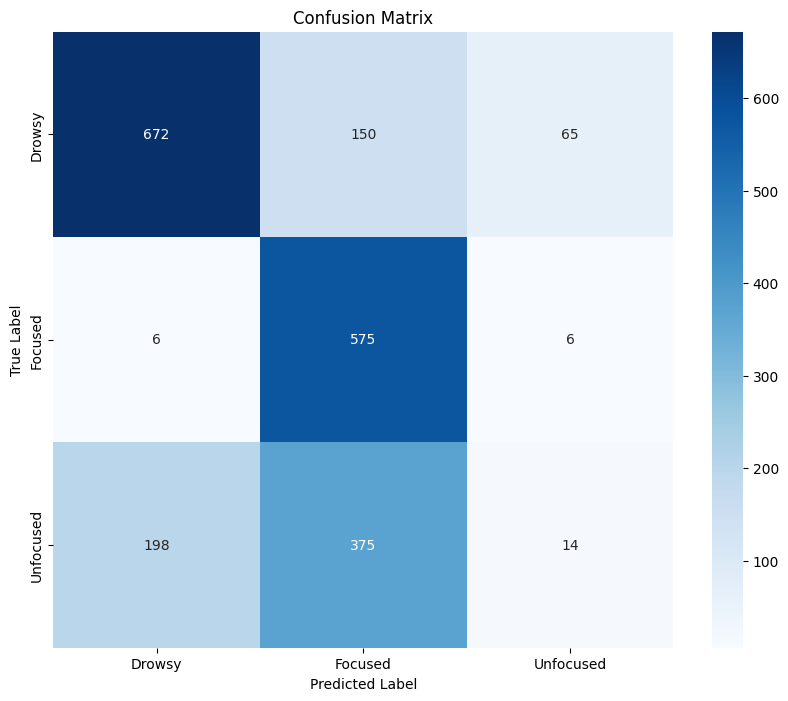

In [36]:
# Normalize the data
scaler_1 = StandardScaler()
X_train_scaled_1 = scaler_1.fit_transform(X_train_1)  # Fit and transform on the training set
X_test_scaled_1 = scaler_1.transform(X_test_1)        # Only transform on the test set

# Initialize the Random Forest model, class_weight="balanced": adjusts weights for imbalanced classes
rf_1 = RandomForestClassifier(random_state=42)

# Train the model on the training set
rf_1.fit(X_train_scaled_1, y_train_1)

# Make predictions on the test set
y_pred_1 = rf_1.predict(X_test_scaled_1)

# Performance report
rf_report_1 = classification_report(y_test_1, y_pred_1, output_dict=True)

plot_confusion_matrix(y_test_1, y_pred_1, class_names=["Drowsy", "Focused", "Unfocused"])

**Subject 2**

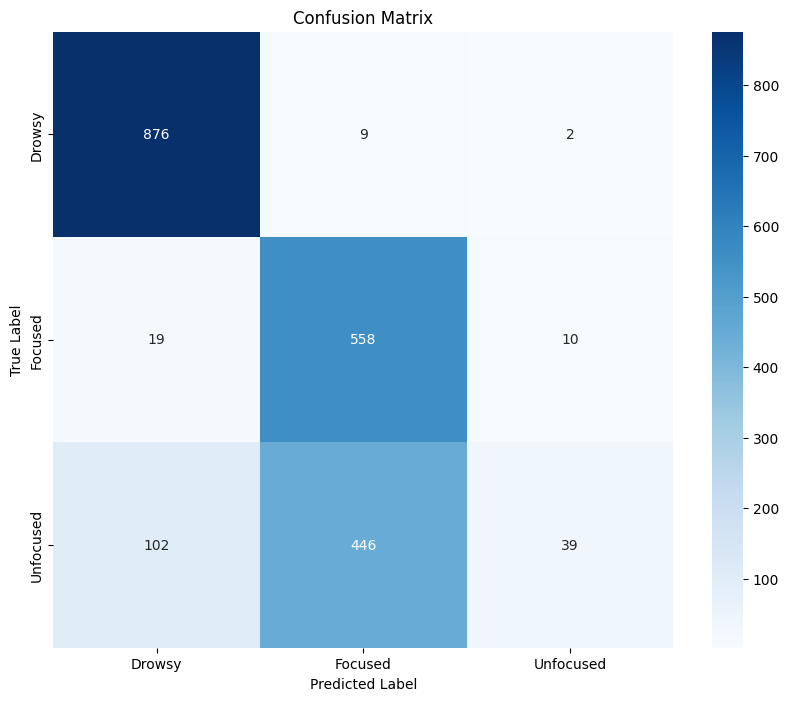

In [37]:
# Normalize the data
scaler_2 = StandardScaler()
X_train_scaled_2 = scaler_2.fit_transform(X_train_2)  # Fit and transform on the training set
X_test_scaled_2 = scaler_2.transform(X_test_2)        # Only transform on the test set

# Initialize the Random Forest model, class_weight="balanced": adjusts weights for imbalanced classes
rf_2 = RandomForestClassifier(random_state=42)

# Train the model on the training set
rf_2.fit(X_train_scaled_2, y_train_2)

# Make predictions on the test set
y_pred_2 = rf_2.predict(X_test_scaled_2)

# Performance report
rf_report_2 = classification_report(y_test_2, y_pred_2, output_dict=True)

plot_confusion_matrix(y_test_2, y_pred_2, class_names=["Drowsy", "Focused", "Unfocused"])


**Subject 3**

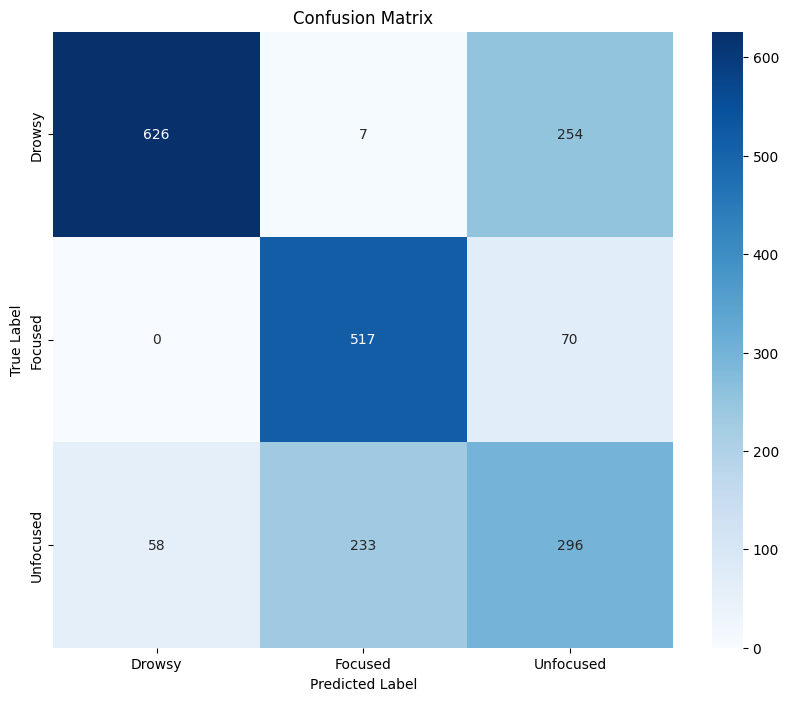

In [38]:
# Normalize the data
scaler_3 = StandardScaler()
X_train_scaled_3 = scaler_3.fit_transform(X_train_3)  # Fit and transform on the training set
X_test_scaled_3 = scaler_3.transform(X_test_3)        # Only transform on the test set

# Initialize the Random Forest model, class_weight="balanced": adjusts weights for imbalanced classes
rf_3 = RandomForestClassifier(random_state=42)

# Train the model on the training set
rf_3.fit(X_train_scaled_3, y_train_3)

# Make predictions on the test set
y_pred_3 = rf_3.predict(X_test_scaled_3)

# Performance report
rf_report_3 = classification_report(y_test_3, y_pred_3, output_dict=True)

plot_confusion_matrix(y_test_3, y_pred_3, class_names=["Drowsy", "Focused", "Unfocused"])

**Subject 4**

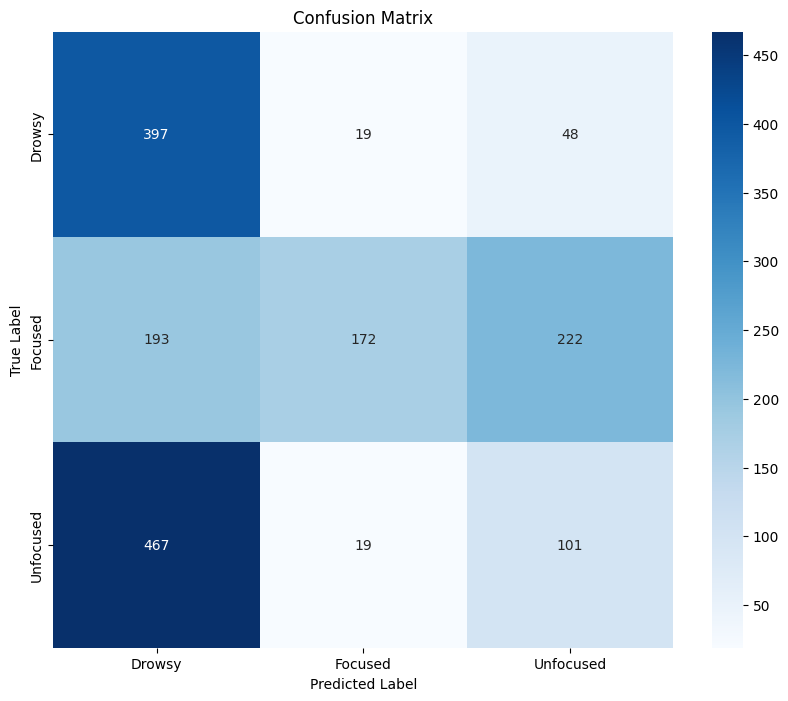

In [39]:
# Normalize the data
scaler_4 = StandardScaler()
X_train_scaled_4 = scaler_4.fit_transform(X_train_4)  # Fit and transform on the training set
X_test_scaled_4 = scaler_4.transform(X_test_4)        # Only transform on the test set

# Initialize the Random Forest model, class_weight="balanced": adjusts weights for imbalanced classes
rf_4 = RandomForestClassifier(random_state=42)

# Train the model on the training set
rf_4.fit(X_train_scaled_4, y_train_4)

# Make predictions on the test set
y_pred_4 = rf_4.predict(X_test_scaled_4)

# Performance report
rf_report_4 = classification_report(y_test_4, y_pred_4, output_dict=True)

plot_confusion_matrix(y_test_4, y_pred_4, class_names=["Drowsy", "Focused", "Unfocused"])

**Subject 5**

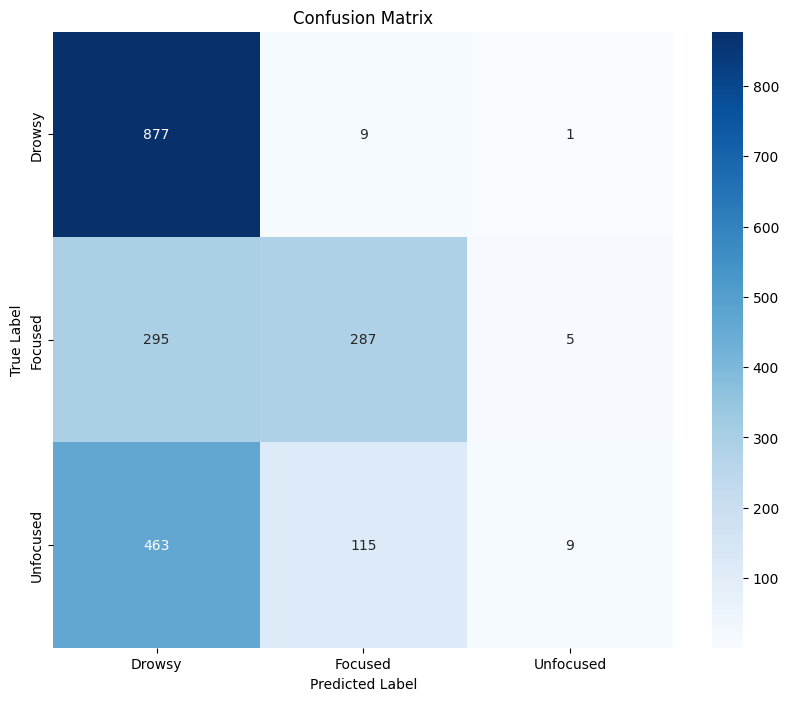

In [40]:
# Normalize the data
scaler_5 = StandardScaler()
X_train_scaled_5 = scaler_5.fit_transform(X_train_5)  # Fit and transform on the training set
X_test_scaled_5 = scaler_5.transform(X_test_5)        # Only transform on the test set

# Initialize the Random Forest model, class_weight="balanced": adjusts weights for imbalanced classes
rf_5 = RandomForestClassifier(random_state=42)

# Train the model on the training set
rf_5.fit(X_train_scaled_5, y_train_5)

# Make predictions on the test set
y_pred_5 = rf_5.predict(X_test_scaled_5)

# Performance report
rf_report_5 = classification_report(y_test_5, y_pred_5, output_dict=True)

plot_confusion_matrix(y_test_5, y_pred_5, class_names=["Drowsy", "Focused", "Unfocused"])

**Compare**

In [41]:
metrics_dict = {}

metrics_dict['Object 1'] = [rf_report_1['accuracy'], rf_report_1['macro avg']['precision'],
                            rf_report_1['macro avg']['recall'], rf_report_1['macro avg']['f1-score']]

metrics_dict['Object 2'] = [rf_report_2['accuracy'], rf_report_2['macro avg']['precision'],
                            rf_report_2['macro avg']['recall'], rf_report_2['macro avg']['f1-score']]

metrics_dict['Object 3'] = [rf_report_3['accuracy'], rf_report_3['macro avg']['precision'],
                            rf_report_3['macro avg']['recall'], rf_report_3['macro avg']['f1-score']]

metrics_dict['Object 4'] = [rf_report_4['accuracy'], rf_report_4['macro avg']['precision'],
                            rf_report_4['macro avg']['recall'], rf_report_4['macro avg']['f1-score']]

metrics_dict['Object 5'] = [rf_report_5['accuracy'], rf_report_5['macro avg']['precision'],
                            rf_report_5['macro avg']['recall'], rf_report_5['macro avg']['f1-score']]

# Chuyển dictionary thành DataFrame
metrics_df = pd.DataFrame(metrics_dict, index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Hiển thị DataFrame
print(metrics_df.round(2))

           Object 1  Object 2  Object 3  Object 4  Object 5
Accuracy       0.61      0.71      0.70      0.41      0.57
Precision      0.48      0.73      0.69      0.49      0.61
Recall         0.59      0.67      0.70      0.44      0.50
F1-Score       0.50      0.58      0.69      0.39      0.43


**Observations on EEG Data for Each Subject**

1. **Individual Differences in EEG**

    - The varying metrics for each subject highlight the heterogeneity of EEG data.

    - EEG data differs significantly between individuals due to factors such as brain structure, physiological conditions, mental state, and environmental influences.

    - This variability makes it challenging to develop a general model for classifying different states (e.g., Focused, Unfocused, Drowsy) across all subjects.

2. **Correlation Between States**

    - Low Precision, Recall, and F1-Score for Subject 4 and Subject 5 indicate that the model struggles to distinguish between different states.

    - This could be due to frequency overlap between states in EEG signals or a lack of clear distinction in EEG features across states.
        - For example, alpha, beta, delta, and theta frequency bands may not be distinctly different between drowsy and unfocused states, leading to misclassification.

**CONCLUSION**

- EEG data is highly personalized, resulting in differences in model performance across subjects.

- A personalized model for each subject may improve accuracy compared to a generalized model.

- The differences in metrics between subjects highlight the complexity of EEG characteristics for individuals and the challenges in classification.

### **Analysis and Visualization**

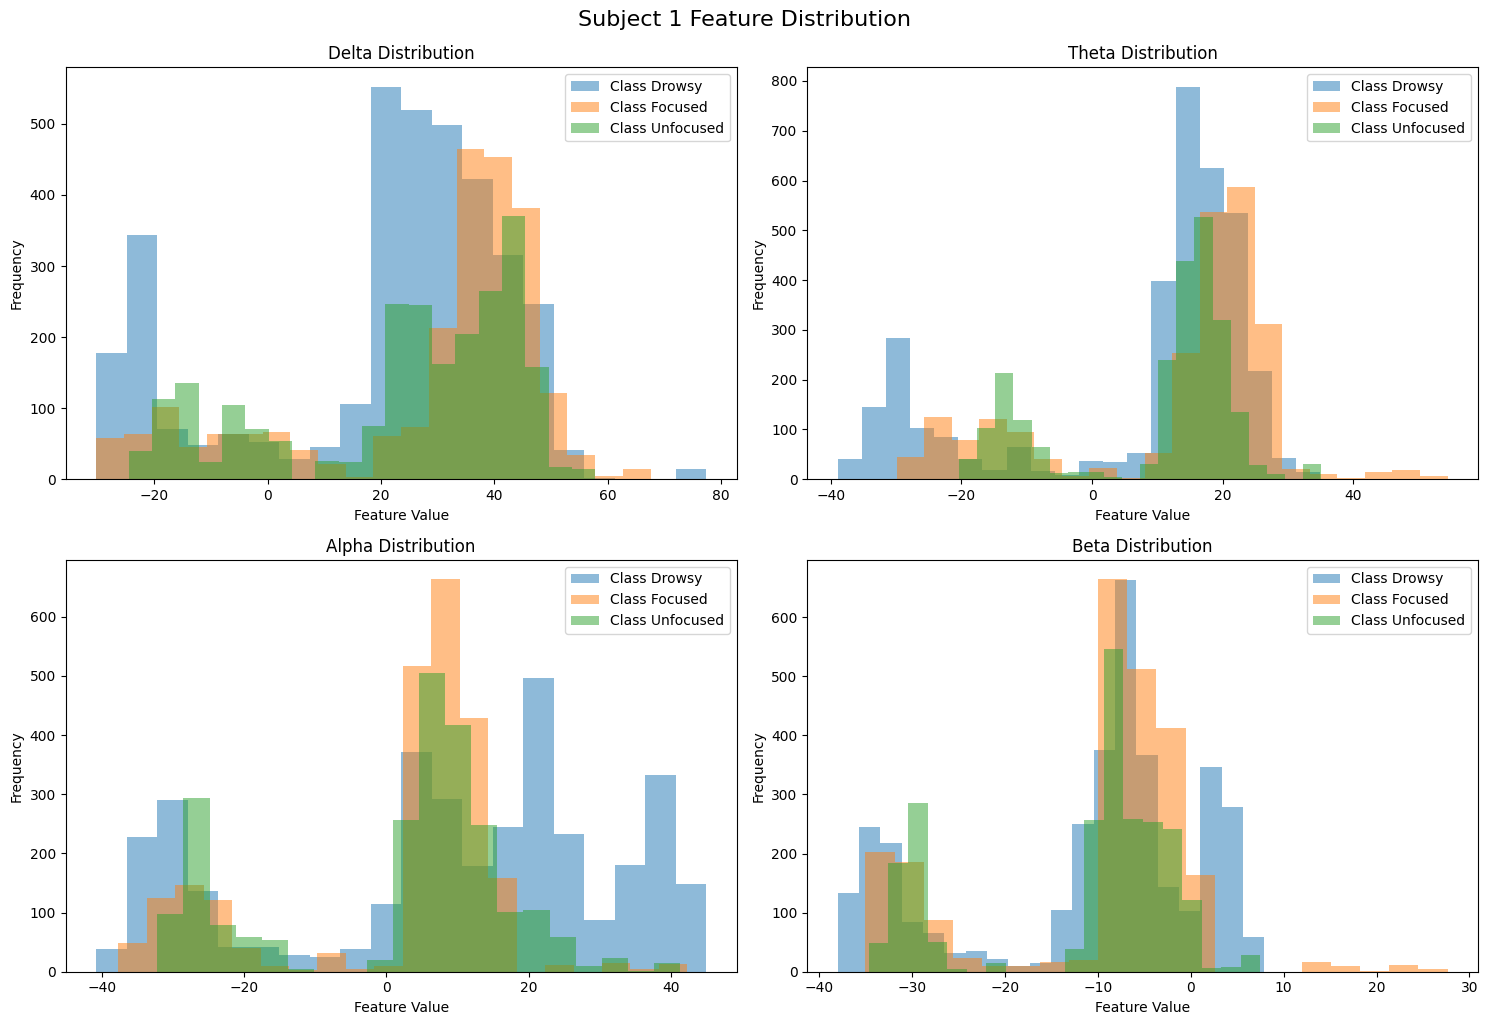

In [42]:
def visualize_feature_distribution(features, labels, feature_names, title="Feature Distribution"):
    """
    Visualize feature distribution across classes using histograms.
    """
    unique_labels = np.unique(labels)
    plt.figure(figsize=(15, 10))

    for i, feature_name in enumerate(feature_names):
        plt.subplot(2, 2, i + 1)
        for label in unique_labels:
            plt.hist(features[labels == label, i], bins=20, alpha=0.5, label=f"Class {label}")
        plt.title(f"{feature_name} Distribution")
        plt.xlabel("Feature Value")
        plt.ylabel("Frequency")
        plt.legend()

    plt.tight_layout()
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.show()

# Example: Visualize feature distributions for Subject 1
visualize_feature_distribution(X_train_1, y_train_1, ["Delta", "Theta", "Alpha", "Beta"], title="Subject 1 Feature Distribution")

- **Delta** and **Theta**: Significantly higher in the `Drowsy` state, indicating their association with drowsiness and loss of focus.

- **Alpha**: Most prominent in the `Focused` state, linked to relaxation and mild concentration.

- **Beta**: Stands out in the `Focused` state, reflecting alertness and high concentration.

**Implications**

- `Drowsy` is distinguished by **Delta** and **Theta**.

- `Focused` is distinguished by **Alpha** and **Beta**.

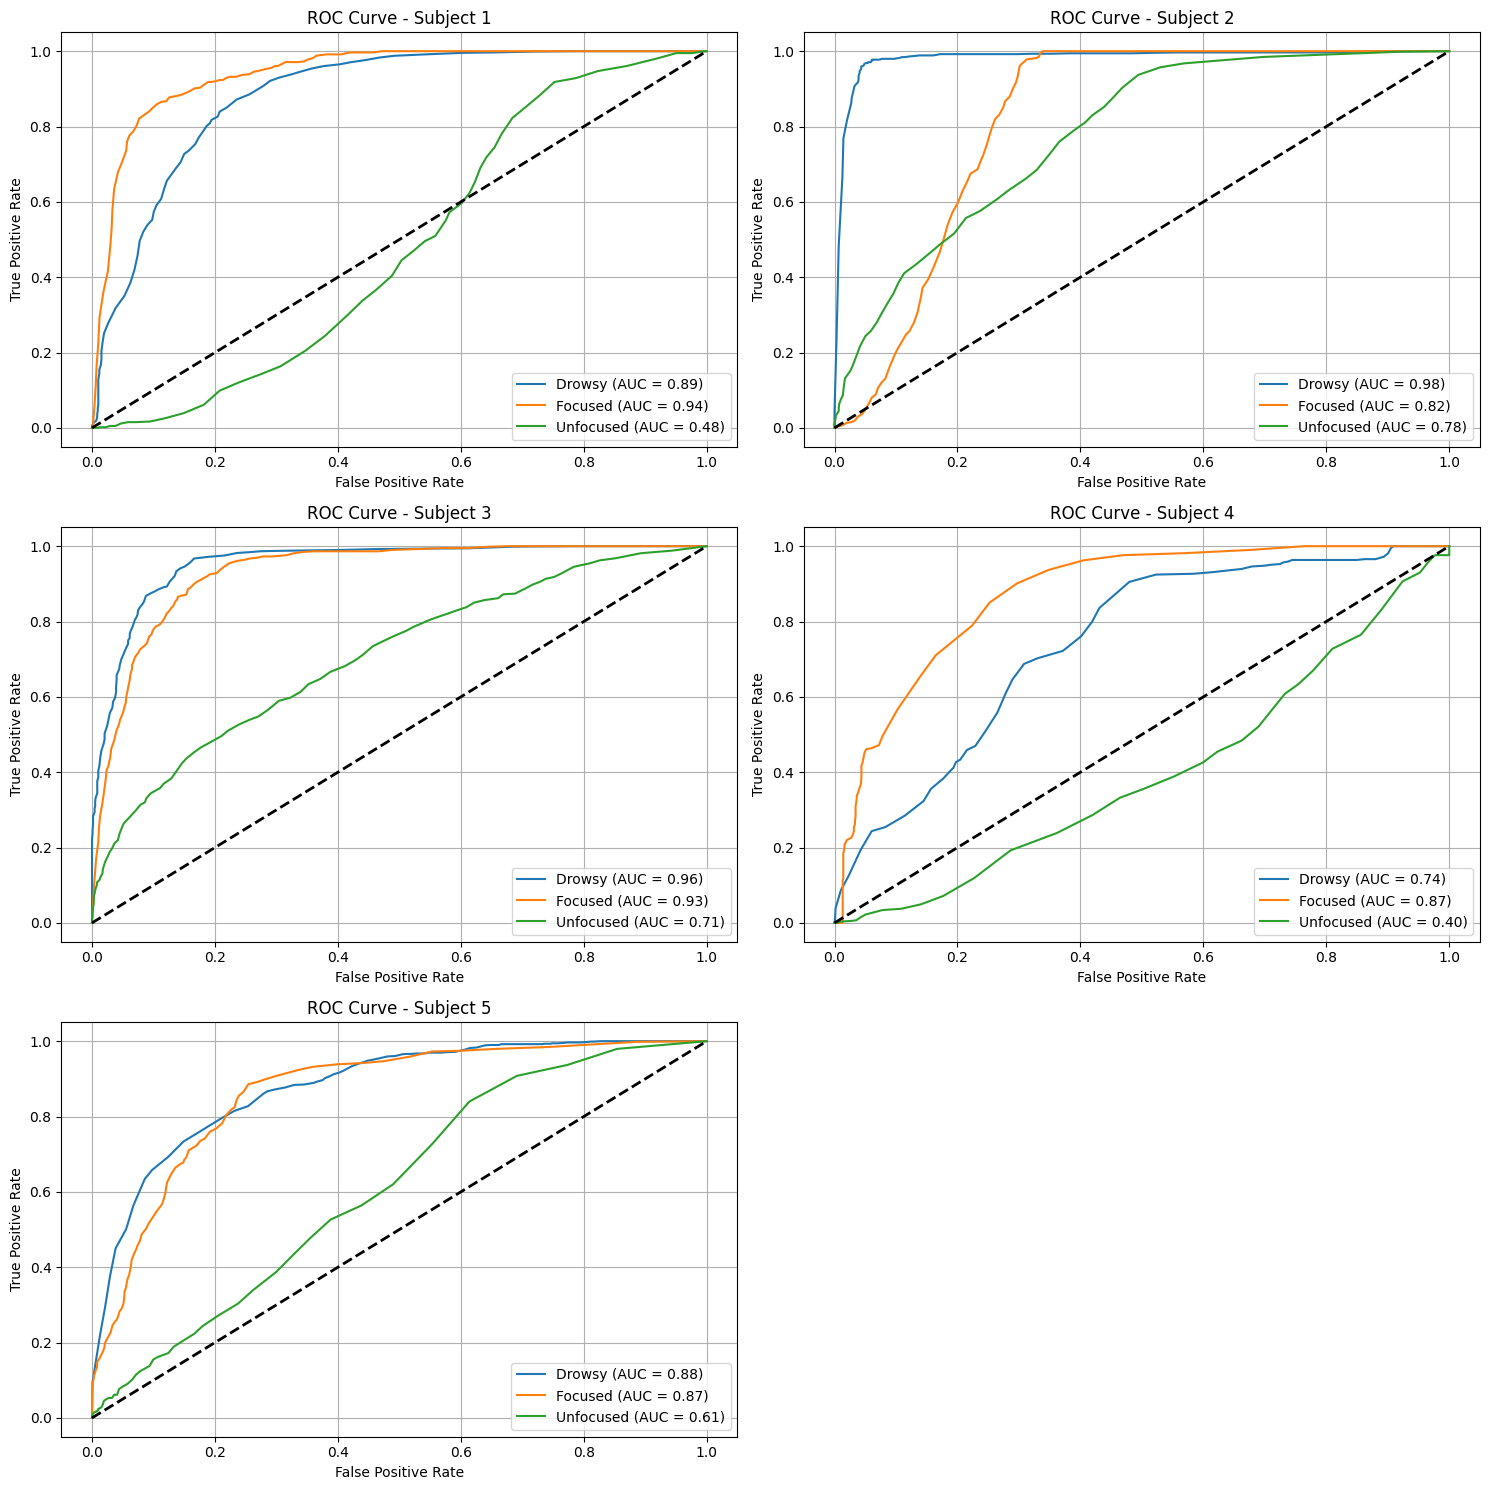

In [43]:
def plot_roc_curves_combined(models, X_tests, y_tests, class_names):
    """
    Plot ROC curves for 5 subjects in a combined grid layout (2x2 + 1 separate plot below).
    models: list of trained models (e.g., Random Forests for each subject).
    X_tests: list of test datasets for each subject.
    y_tests: list of true labels for each subject.
    class_names: list of class names (for multi-class ROC).
    """
    plt.figure(figsize=(15, 15))  # Increase height to match the plots
    gridspec = plt.GridSpec(3, 2)  # Split grid into 3 rows, 2 columns

    for i, (model, X_test, y_test) in enumerate(zip(models, X_tests, y_tests)):
        y_prob = model.predict_proba(X_test)  # Predicted probabilities
        y_true_bin = label_binarize(y_test, classes=np.unique(y_test))  # Binarize labels
        n_classes = y_true_bin.shape[1]

        # Plot position in the grid
        if i < 4:  # 2x2 grid for the first 4 subjects
            ax = plt.subplot(gridspec[i // 2, i % 2])  # Row, column based on the order
        else:  # Subject 5 in the last row, first column
            ax = plt.subplot(gridspec[2, 0])  # Place in row 3, column 1

        # Plot ROC for each class
        for j in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true_bin[:, j], y_prob[:, j])
            roc_auc = auc(fpr, tpr)
            ax.plot(fpr, tpr, label=f"{class_names[j]} (AUC = {roc_auc:.2f})")

        ax.plot([0, 1], [0, 1], "k--", lw=2)  # Diagonal line
        ax.set_title(f"ROC Curve - Subject {i + 1}")
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.legend(loc="lower right")
        ax.grid()

    # Hide the last box (row 3, column 2) to avoid displaying an empty plot
    plt.subplot(gridspec[2, 1]).axis("off")

    plt.tight_layout()
    plt.show()

# Example Usage
models = [rf_1, rf_2, rf_3, rf_4, rf_5]
X_tests = [X_test_scaled_1, X_test_scaled_2, X_test_scaled_3, X_test_scaled_4, X_test_scaled_5]
y_tests = [y_test_1, y_test_2, y_test_3, y_test_4, y_test_5]
class_names = ["Drowsy", "Focused", "Unfocused"]

# Plot combined ROC curves
plot_roc_curves_combined(models, X_tests, y_tests, class_names)

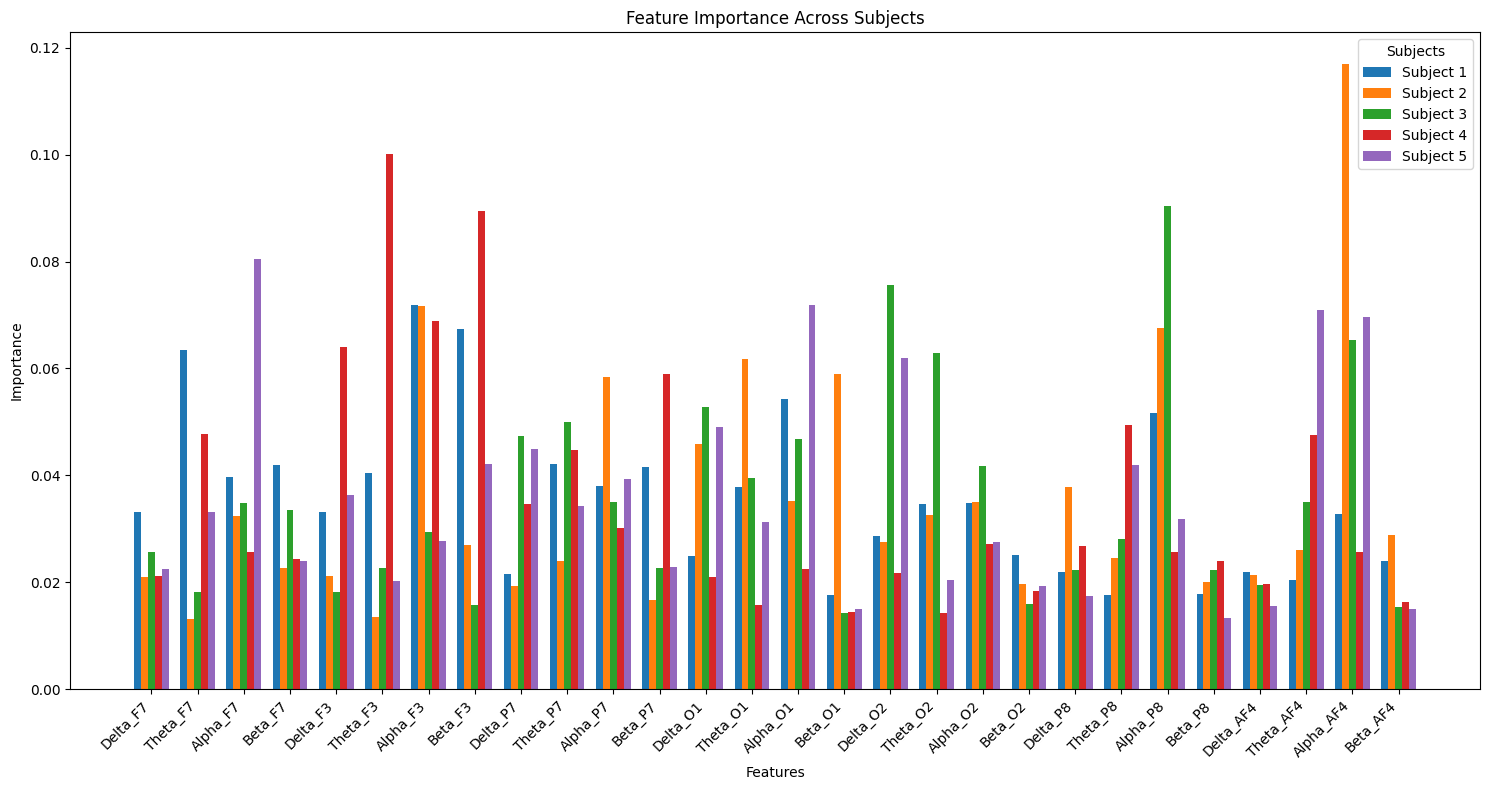

In [44]:
def plot_feature_importance_multiple(models, feature_names, subject_names):
    """
    Plot feature importance for multiple subjects in a grouped bar plot.
    models: list of trained Random Forest models (one for each subject).
    feature_names: list of feature names.
    subject_names: list of subject names.
    """
    num_features = len(feature_names)
    num_subjects = len(models)

    # Collect feature importances for all subjects
    importances = np.zeros((num_subjects, num_features))
    for i, model in enumerate(models):
        importances[i, :] = model.feature_importances_

    # Define bar width and positions
    bar_width = 0.15
    x = np.arange(num_features)  # X-axis positions for features
    offsets = np.arange(-(num_subjects - 1) / 2, (num_subjects + 1) / 2) * bar_width  # Offsets for subjects

    # Plot grouped bar chart
    plt.figure(figsize=(15, 8))
    for i, (importance, offset) in enumerate(zip(importances, offsets)):
        plt.bar(x + offset, importance, bar_width, label=subject_names[i])

    # Add labels, legend, and formatting
    plt.xticks(x, feature_names, rotation=45, ha="right")
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.title("Feature Importance Across Subjects")
    plt.legend(title="Subjects")
    plt.tight_layout()
    plt.show()

# Example Usage
# Assuming rf_1, rf_2, rf_3, rf_4, rf_5 are Random Forest models for 5 subjects
models = [rf_1, rf_2, rf_3, rf_4, rf_5]
subject_names = ["Subject 1", "Subject 2", "Subject 3", "Subject 4", "Subject 5"]

# Generate feature names (e.g., for 7 channels and 4 frequency bands)
channels = ["F7", "F3", "P7", "O1", "O2", "P8", "AF4"]
feature_names = [f"{band}_{channel}" for channel in channels for band in ["Delta", "Theta", "Alpha", "Beta"]]

# Plot feature importance for all subjects
plot_feature_importance_multiple(models, feature_names, subject_names)